<a href="https://colab.research.google.com/github/mohamedyosef101/101_learning_area/blob/area/PyTorch/01_vanilla_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vanilla** Neural Network
The original notebook created by [Andrada](https://www.kaggle.com/code/andradaolteanu/how-i-taught-myself-deep-learning-vanilla-nns#1.-Introduction)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader as dl

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import random
import os

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Available device:", device)

Available device: cpu


In [40]:
# SEED
def set_seed(seed = 7):
  '''Sets the seed of the entire notebook so
  results are the same every time we run.'''
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

# 1. **Load** the data

In [41]:
# hide the output
%%capture

train = datasets.MNIST('data',
                       train=True,
                       download=True,
                       transform=ToTensor())

test = datasets.MNIST('data',
                      train=False,
                      download=True,
                      transform=ToTensor())

# 2. Data **Exploration**

In [42]:
image, label = train[0]
image.shape

torch.Size([1, 28, 28])

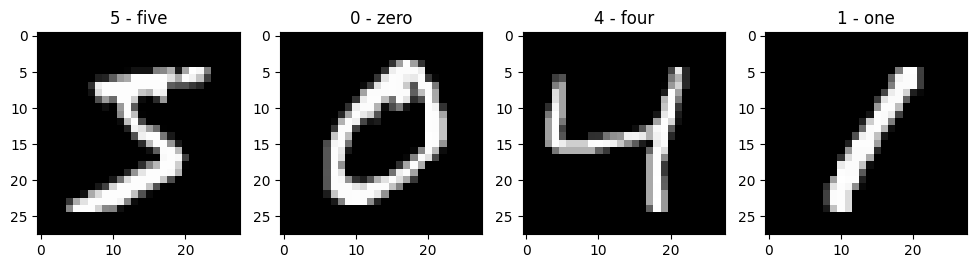

In [43]:
# get a sample
plt.figure(figsize=(12, 3))
for i in range(4):
  image, label = train[i]
  plt.subplot(1, 4, i+1)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(train.classes[label])

# 3. **Initial** Model

In [44]:
class MNISTClassifier(nn.Module):
  def __init__(self):
    super(MNISTClassifier, self).__init__()
    self.layers = nn.Sequential(nn.Linear(28*28, 50),
                                nn.ReLU(),
                                nn.Linear(50, 20),
                                nn.ReLU(),
                                nn.Linear(20, 10))

  def forward(self, image, prints=False):
    if prints: print(f'Image shape: {image.detach().numpy().shape}')

    # flatten image from [1, 28, 28] to [784]
    image = image.view(-1, 28*28)
    if prints: print(f"Image reshaped: {image.detach().numpy().shape}")

    out = self.layers(image)
    if prints: print('Out shape:', out.detach().numpy().shape)

    return out

`detach().numpy()` is just a way to make the output look nicer.

### Check the model

In [45]:
image_example, label_example = train[5]
print('The true label is:', label_example, '\n')

model_example = MNISTClassifier()

out = model_example(image_example, prints=True)
print('\n', 'out:', out.detach().numpy(), '\n')

# Choose max prob.
pred = out.max(dim=1)[1]
pred = pred.item()

print('prediction:', pred, '\n')

print('Model get it -> ', pred == label_example)

The true label is: 2 

Image shape: (1, 28, 28)
Image reshaped: (1, 784)
Out shape: (1, 10)

 out: [[ 0.10805383  0.08670035  0.1381453   0.07652353 -0.2029747   0.00852526
   0.19843227  0.08236697  0.20576206 -0.25752056]] 

prediction: 8 

Model get it ->  False


### Loss and Optimizer

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_example.parameters(), lr=0.005, momentum=0.9)

print('Loss:', criterion, '\n', '\n' +
      'Optimizer:', optimizer)

Loss: CrossEntropyLoss() 
 
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


### Model Parameters & Backpropagation
How many parameters (weights and biases) are updating during 1 single backpropagation.

In [47]:
params = list(model_example.parameters())

for i in range(len(params)):
  print('Parameter', i+1, ':', params[i].detach().numpy().shape)

Parameter 1 : (50, 784)
Parameter 2 : (50,)
Parameter 3 : (20, 50)
Parameter 4 : (20,)
Parameter 5 : (10, 20)
Parameter 6 : (10,)


In [48]:
# clear gradients
optimizer.zero_grad()

# compute loss
loss = criterion(out, torch.tensor(label_example).reshape(-1))
print(f'Loss: {loss.detach().numpy():.2f}')

# compute gradients
loss.backward()

# update weights
optimizer.step()

Loss: 2.22


# 4. **Training** Neural Network

Create a `DataLoader` and  split the data into 1000 batch each one with size of 60 data point.

> `shuffle=True` to shuffle the images after every epoch.

In [49]:
# Data Loader -> dl
train_loader = dl(train, batch_size=60, shuffle=True)
test_loader = dl(test, batch_size=10, shuffle=True)

# select first batch
images, labels = next(iter(train_loader))
print('Object shape:', images.detach().numpy().shape, '\n\n' +
      'Total Inages:', labels.detach().numpy().shape)

Object shape: (60, 1, 28, 28) 

Total Inages: (60,)


### Train 3 batches

In [50]:
n = 0
for i, (images, labels) in enumerate(train_loader):
  if i >= 3: break

  print(f'====== Batch {i}:')
  out = model_example(images, prints=True)

  loss = criterion(out, labels)
  print(f'loss: {loss.detach().numpy():.2f}')

  print('Optimizing...')
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  print('Done.')

  if i < 2: print('\n')

====== Batch 0:
Image shape: (60, 1, 28, 28)
Image reshaped: (60, 784)
Out shape: (60, 10)
loss: 2.32
Optimizing...
Done.


====== Batch 1:
Image shape: (60, 1, 28, 28)
Image reshaped: (60, 784)
Out shape: (60, 10)
loss: 2.32
Optimizing...
Done.


====== Batch 2:
Image shape: (60, 1, 28, 28)
Image reshaped: (60, 784)
Out shape: (60, 10)
loss: 2.29
Optimizing...
Done.


### Accuracy example

In [51]:
# Initiate 2 variables for total cases and correct cases
correct = 0
total = 0

model_example.eval()

for i, (images, labels) in enumerate(train_loader):
  if i >= 3: break

  print(f'======== Batch {i}:')

  out = model_example(images)
  print('Out shape:', out.detach().numpy().shape)

  pred = out.max(dim=1)[1]
  print('Prediction:', pred.detach().numpy().shape)

  correct += (pred == labels).sum().item()
  print('Correct:', correct)

  total += images.shape[0]
  print('Total:', total)

  if i < 2: print('\n')

print(f'\n\nAverage Accuracy after 3 iterations: {correct/total:.2f}')

======== Batch 0:
Out shape: (60, 10)
Prediction: (60,)
Correct: 6
Total: 60


======== Batch 1:
Out shape: (60, 10)
Prediction: (60,)
Correct: 11
Total: 120


======== Batch 2:
Out shape: (60, 10)
Prediction: (60,)
Correct: 17
Total: 180


Average Accuracy after 3 iterations: 0.09


# 5. Model **Evaluation**

### **Predefined** Functions

In [52]:
def get_accuracy(model, data, batchSize = 20):
  model.eval()
  data_loader = dl(data, batch_size=batchSize)

  correct = 0
  total = 0

  for (images, labels) in iter(data_loader):
    out = model(images)
    pred = out.max(dim=1)[1]
    correct += (pred == labels).sum().item()
    total += images.shape[0]

  return correct/total

In [53]:
def train_network(model, train_data, test_data, batchSize=20,
                  num_epochs=1, learning_rate=0.01, weight_decay=0,
                  show_plot=True, show_acc=True):

  print('Get data ready...')
  train_loader = dl(dataset=train_data, batch_size=batchSize, shuffle=True)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                        momentum=0.9, weight_decay=weight_decay)

  losses = []
  iterations = []
  train_acc = []
  test_acc = []

  print('Training started...')
  iteration = 0

  for epoch in range(num_epochs):
    for images, labels in iter(train_loader):
      model.train()
      out = model(images)

      optimizer.zero_grad()
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()

      iterations.append(iteration)
      iteration += 1
      losses.append(loss.data)

      train_acc.append(get_accuracy(model, train_data))
      test_acc.append(get_accuracy(model, test_data))

  if show_acc:
    print(f"Final Training Accuracy: {train_acc[-1]}")
    print(f"Final Testing Accuracy: {test_acc[-1]}")

  if show_plot:
    plt.figure(figsize=(10,4))

    # Plot 1 -> Loss
    plt.subplot(1, 2, 1)
    plt.title("Loss Curve")
    plt.plot(iterations, losses, label="Train", color='gray')
    plt.xlabel('Iterations')
    plt.ylabel("Loss")

    # plot 2 -> Accuracy
    plt.subplot(1, 2, 2)
    plt.title("Accuracy Curve")
    plt.plot(iterations, train_acc, label="Train", color='gray')
    plt.plot(iterations, test_acc, label="Test", color='black')
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")

    plt.legend(loc='best')
    plt.show()


### Try it

Get data ready...
Training started...
Final Training Accuracy: 1.0
Final Testing Accuracy: 0.788


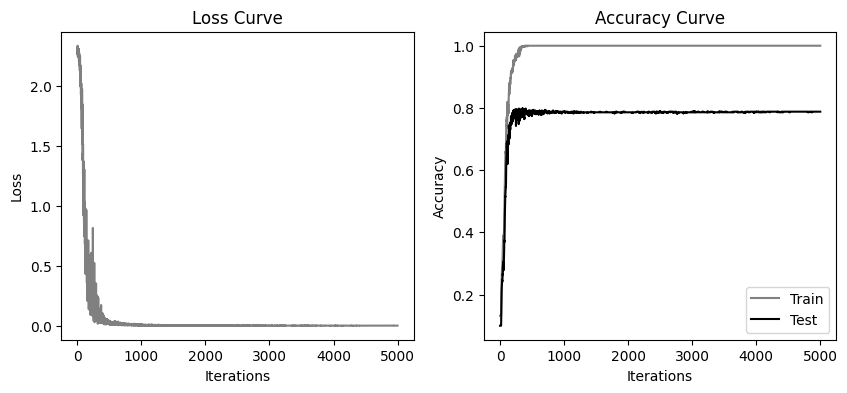

In [54]:
# select only 500 images for faster training
mnist_data = datasets.MNIST('data', train=True,
                            download=True, transform=ToTensor())
mnist_data = list(mnist_data)

mnist_train = mnist_data[:500]
mnist_test = mnist_data[500:1000]

model1 = MNISTClassifier()

train_network(model1, mnist_train, mnist_test, num_epochs=200)

# 6. **Over**fitting
There are a lot of ways to deal with the overfitting problem.

# Data **Aug**mentation

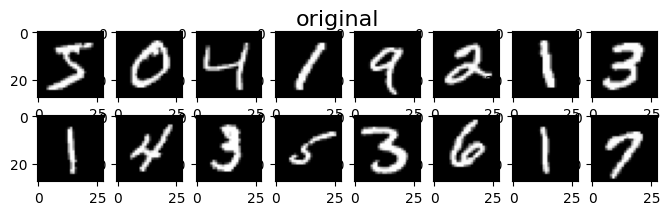

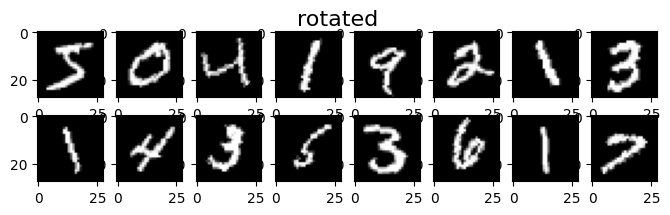

In [55]:
### Rotate images randomly up to 35 degrees ###

# Predefined function
def show16(data, title="Default"):
  plt.figure(figsize=(8,2))
  for i, (image, label) in enumerate(data):
    if i >= 16: break

    plt.subplot(2, 8, i+1)
    plt.imshow(image, cmap='gray')
    plt.suptitle(title, fontsize=16)


# create original and rotated set
original = datasets.MNIST('data', train=True, download=True)

transform = transforms.RandomRotation(25, fill=(0,))
rotated = datasets.MNIST('data', train=True,
                         download=True, transform=transform)

# show images
show16(original, 'original')
show16(rotated, 'rotated')

In [56]:
### Creating a personalized transform ###
# first rotates, then to tensor, then normalize
mytransform = transforms.Compose([transforms.RandomRotation(25, fill=(0,)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5], [0.5])])

In [57]:
# import the data applying the transformations
data_aug = datasets.MNIST('data', train=True,
                          download=True, transform=mytransform)
data_aug = list(data_aug)

train_aug = data_aug[:500]

Get data ready...
Training started...
Final Training Accuracy: 1.0
Final Testing Accuracy: 0.676


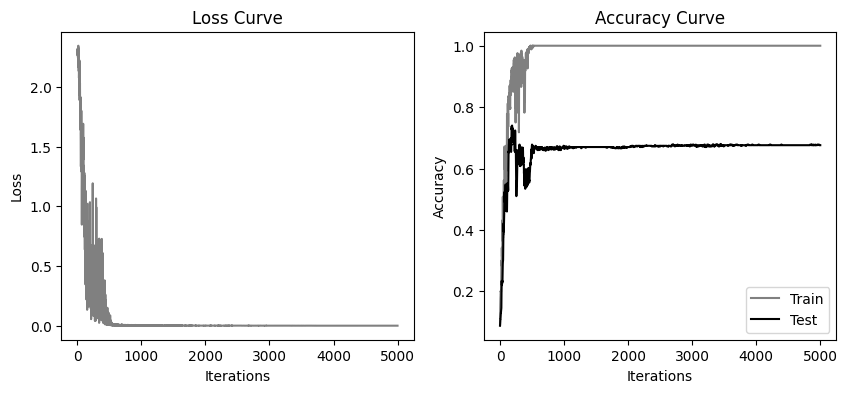

In [58]:
# Training the model
model_aug = MNISTClassifier()
train_network(model_aug, train_aug, mnist_test, num_epochs=200)

# Weight Decay and Learning Rate

Get data ready...
Training started...
Final Training Accuracy: 1.0
Final Testing Accuracy: 0.814


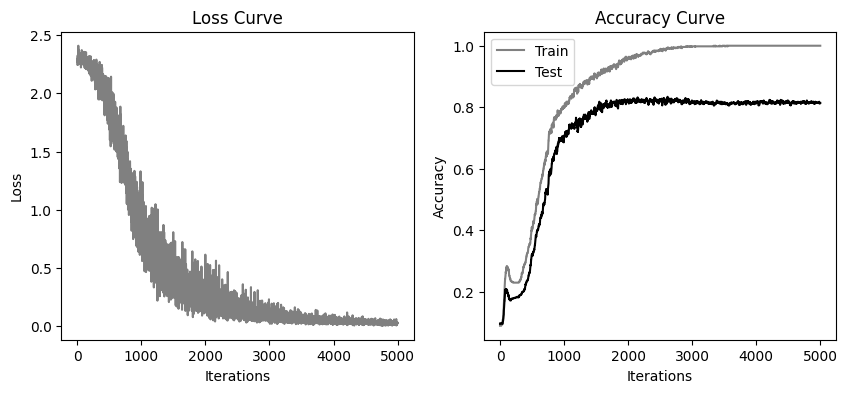

In [59]:
model2 = MNISTClassifier()

# Train
train_network(model2, mnist_train, mnist_test, num_epochs=200,
              learning_rate=0.001, weight_decay=0.0005)

# Dropout and Layer Optimization

- `nn.Dropout(p=0.4)`: each neuron has 40% chance of being dropped.
- `layer1_size`: size of the first hidden layer
- `layer2_size`: size of the second hidden layer

In [60]:
class MNISTClassifier_improved(nn.Module):
  def __init__(self, layer1_size=50, layer2_size=20, dropout=0.4):
    super(MNISTClassifier_improved, self).__init__()

    self.layers = nn.Sequential(nn.Dropout(p=dropout),
                                nn.Linear(28*28, layer1_size),
                                nn.ReLU(),

                                nn.Dropout(p=dropout),
                                nn.Linear(layer1_size, layer2_size),
                                nn.ReLU(),

                                nn.Dropout(p=dropout),
                                nn.Linear(layer2_size, 10))

  def forward(self, image):
    image = image.view(-1, 28*28) # flatten
    out = self.layers(image) # Log probabilities
    return out

Get data ready...
Training started...
Final Training Accuracy: 1.0
Final Testing Accuracy: 0.852


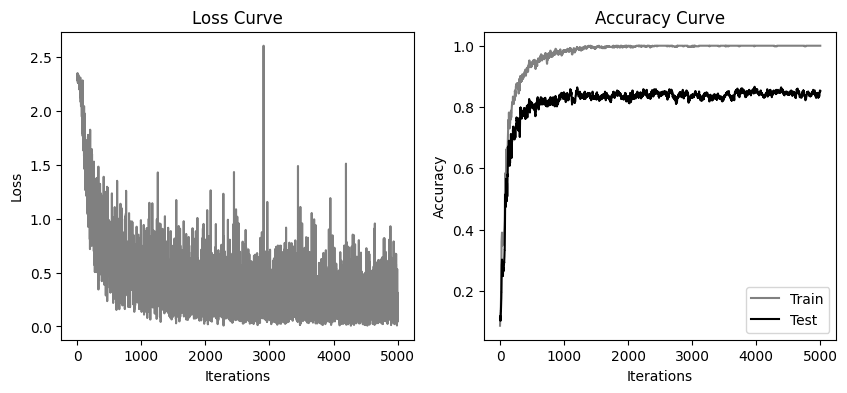

In [61]:
# Training
model_improved = MNISTClassifier_improved(layer1_size=80, layer2_size=50,
                                          dropout=0.5)
train_network(model_improved, mnist_train, mnist_test, num_epochs=200)

# Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

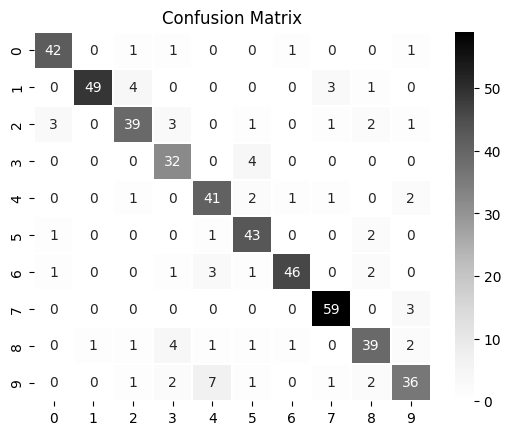

In [62]:
def confusion_matrix(model, test_data):
  torch.no_grad() # disable gradient computing
  model.eval()

  preds, actuals = [], []

  for image, label in test_data:
    image = image.unsqueeze(0) # add 1 dimension for batching
    out = model(image)

    pred = torch.max(out, dim=1)[1].item()
    preds.append(pred)
    actuals.append(label)

  return metrics.confusion_matrix(preds, actuals)


# get the plot
sns.heatmap(confusion_matrix(model_improved, mnist_test), linewidths=0.1,
            annot=True, fmt='g', cmap='Greys')
plt.title('Confusion Matrix')

# END